In [1]:
import pandas as pd
import duckdb
import json
import warnings

In [6]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

In [2]:
import plotly.graph_objects as go
import plotly.express as px

In [287]:
conn = duckdb.connect('secrets/cws_data.db')

In [286]:
conn.close()

In [ ]:
def query(query_string, df=False)

## proposals over years
- proposals by year
- proposals by category over year
    - with rejects and without rejects
- voting trends by category
- unique voters by category

In [224]:
conn.sql("""SELECT * FROM roles WHERE year = 2021 AND username IS NULL AND role = 'voter'""")

┌───────┬──────────┬─────────┬──────────┐
│ year  │ proposal │  role   │ username │
│ int32 │ varchar  │ varchar │ varchar  │
├───────────────────────────────────────┤
│                0 rows                 │
└───────────────────────────────────────┘

In [225]:
conn.sql("""SELECT r.*, p.category FROM roles r JOIN proposals p ON p.year = r.year AND p.proposal = r.proposal WHERE p.year = 2019 AND username IS NULL AND role = 'voter'""") 

┌───────┬──────────┬─────────┬──────────┬──────────┐
│ year  │ proposal │  role   │ username │ category │
│ int32 │ varchar  │ varchar │ varchar  │ varchar  │
├──────────────────────────────────────────────────┤
│                      0 rows                      │
└──────────────────────────────────────────────────┘

In [233]:
conn.sql("""SELECT year, COUNT(*) FROM proposals GROUP BY year""")

┌───────┬──────────────┐
│ year  │ count_star() │
│ int32 │    int64     │
├───────┼──────────────┤
│  2015 │          107 │
│  2016 │          265 │
│  2017 │          321 │
│  2019 │          317 │
│  2020 │          118 │
│  2021 │          412 │
│  2022 │          454 │
│  2023 │          264 │
└───────┴──────────────┘

In [291]:
ap23 = conn.sql("""SELECT * FROM accepted_proposals WHERE year = 2023""").df()

In [292]:
ap23.query("""proposal != @prop.proposal.values.tolist()""")

,year,category,proposal
26,2023,Bots_and_gadgets,Make Navigation Popups work on grandchild sub-...
29,2023,Bots_and_gadgets,Support ASGI on Toolforge
61,2023,Larger_suggestions,Fix unified login to Wikidata and Commons
62,2023,Larger_suggestions,Add semantics of processes
63,2023,Larger_suggestions,Finalize Gadgets 2.0
64,2023,Larger_suggestions,Improve speed at which InternetArchiveBot arch...
66,2023,Larger_suggestions,Wikinews mobile app
67,2023,Larger_suggestions,Allow for searching for the start and end of a...
68,2023,Larger_suggestions,Train a language model to perform SPARQL queries
69,2023,Larger_suggestions,Wiki-ancestry


In [283]:
prop = conn.sql("""
SELECT
    *
FROM
    accepted_proposals ap
    LEFT JOIN roles rl ON ap.year = rl.year AND ap.proposal = rl.proposal
WHERE ap.year = 2023 AND role='proposer'

""").df()

In [128]:
all_categories_by_year = conn.sql("""
WITH base AS (
SELECT *, NULL AS error FROM proposals
UNION ALL
SELECT * FROM errors),

yearly AS (SELECT
    year, category, COUNT(DISTINCT proposal) AS proposals 
FROM base 
WHERE NOT category IN ('Archive', 'Untranslated') AND year <> 2020
GROUP BY year, category)

PIVOT yearly
ON category
USING SUM(proposals)
GROUP BY year""").df()

all_categories_by_year

,year,Anti-harassment,Bots_and_gadgets,Citations,Communication_tools,Editing,Larger_suggestions,Maps,Miscellaneous,Mobile_and_apps,Moderation_tools,Multimedia_and_Commons,Navigation_tools,New_contributors,Programs_and_events,Reading,Templates,Translation,Watchlists,WikiProjects,Wikidata,Wikisource,Wikiversity,Wiktionary
0,2015,NaN,4.0,NaN,9.0,13.0,NaN,NaN,17.0,NaN,13.0,11.0,12.0,NaN,NaN,4.0,3.0,NaN,7.0,NaN,7.0,6.0,1.0,NaN
1,2016,NaN,13.0,6.0,NaN,34.0,NaN,NaN,34.0,10.0,22.0,44.0,11.0,NaN,7.0,10.0,NaN,NaN,24.0,2.0,26.0,18.0,NaN,4.0
2,2017,4.0,15.0,8.0,NaN,48.0,NaN,NaN,47.0,21.0,22.0,45.0,9.0,NaN,4.0,16.0,NaN,NaN,23.0,NaN,40.0,11.0,NaN,9.0
3,2019,5.0,13.0,15.0,4.0,46.0,NaN,13.0,49.0,19.0,15.0,31.0,22.0,NaN,4.0,12.0,NaN,NaN,14.0,NaN,32.0,14.0,NaN,10.0
4,2021,10.0,24.0,14.0,9.0,75.0,NaN,NaN,44.0,30.0,31.0,45.0,33.0,NaN,NaN,28.0,NaN,10.0,22.0,NaN,26.0,6.0,NaN,6.0
5,2022,14.0,23.0,19.0,9.0,52.0,57.0,NaN,54.0,24.0,17.0,36.0,31.0,NaN,NaN,24.0,NaN,17.0,13.0,NaN,29.0,14.0,NaN,9.0
6,2023,9.0,13.0,6.0,17.0,31.0,30.0,NaN,28.0,4.0,18.0,33.0,12.0,6.0,NaN,12.0,NaN,9.0,NaN,NaN,17.0,7.0,NaN,7.0


In [129]:
viz_categories = pd.DataFrame(all_categories_by_year.sum(axis=0, min_count=2)).dropna().index.values
categories_by_year = all_categories_by_year[viz_categories]
categories_by_year = categories_by_year.fillna(0).astype(int)
categories_by_year

,year,Anti-harassment,Bots_and_gadgets,Citations,Communication_tools,Editing,Larger_suggestions,Miscellaneous,Mobile_and_apps,Moderation_tools,Multimedia_and_Commons,Navigation_tools,Programs_and_events,Reading,Translation,Watchlists,Wikidata,Wikisource,Wiktionary
0,2015,0,4,0,9,13,0,17,0,13,11,12,0,4,0,7,7,6,0
1,2016,0,13,6,0,34,0,34,10,22,44,11,7,10,0,24,26,18,4
2,2017,4,15,8,0,48,0,47,21,22,45,9,4,16,0,23,40,11,9
3,2019,5,13,15,4,46,0,49,19,15,31,22,4,12,0,14,32,14,10
4,2021,10,24,14,9,75,0,44,30,31,45,33,0,28,10,22,26,6,6
5,2022,14,23,19,9,52,57,54,24,17,36,31,0,24,17,13,29,14,9
6,2023,9,13,6,17,31,30,28,4,18,33,12,0,12,9,0,17,7,7


In [290]:
# voting trend

conn.sql("""
CREATE OR REPLACE VIEW accepted_proposals AS
SELECT
    p.year,
    p.category,
    p.proposal
FROM
    proposals p
    LEFT JOIN rejects r
    ON p.year = r.year AND p.proposal = r.proposal 
WHERE 
    r.proposal IS NULL
""")

In [244]:
conn.sql("""SELECT * FROM rejects""")

┌───────┬───────────────────────────────────────────┬──────────────────────────────────────────────────────────────────┐
│ year  │                 proposal                  │                              reason                              │
│ int32 │                  varchar                  │                             varchar                              │
├───────┼───────────────────────────────────────────┼──────────────────────────────────────────────────────────────────┤
│  2017 │ Removal_from_the_implicit_permissions_a…  │                                                                  │
│  2017 │ _The_possibility_of_undeletion_images_a…  │                                                                  │
│  2017 │ _The_possibility_of_removeing_links_to_…  │                                                                  │
│  2017 │ Private_protection                        │                                                                  │
│  2017 │ Deleting_"Talk_page_of

In [246]:
roles_by_year = conn.sql("""
SELECT
    ap.year,
    role,
    COUNT(DISTINCT username) AS users
FROM
    accepted_proposals ap
    JOIN roles rl ON ap.year = rl.year AND ap.proposal = rl.proposal
GROUP BY
    ap.year,
    role
ORDER BY
    ap.year,
    role

""").df()

In [249]:
roles_by_year

,year,role,users
0,2015,discussant,195
1,2015,proposer,79
2,2015,voter,534
3,2016,discussant,370
4,2016,proposer,163
5,2016,voter,891
6,2017,discussant,362
7,2017,proposer,147
8,2017,voter,975
9,2019,discussant,480


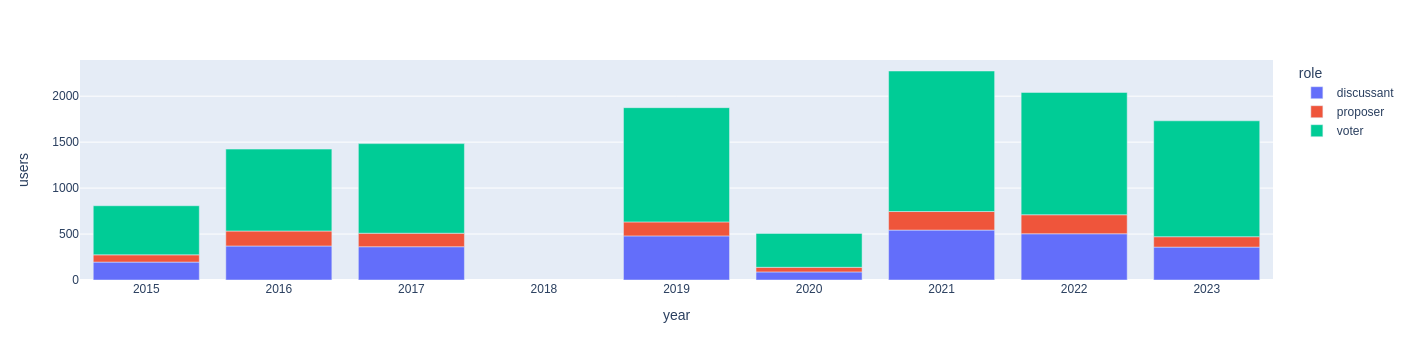

In [247]:
fig = px.bar(roles_by_year, x='year', y='users', color='role')
fig.show()

## patterns
- repetition of proposers and voters
- cross proposal engagement by year